<a href="https://colab.research.google.com/github/IvoandricGBC/Project-MLI-GBC/blob/main/colab_modular_distance_estimation_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Distance Estimation — Modular Pipeline (FULL + CROPPED + Guards + Hold‑out)
Ready for Google Colab. This notebook: 1) Mounts Drive and defines paths. 2) Writes the modular architecture to disk (config.py, data.py, models.py, utils/, train.py, eval.py, predict.py, main.py). 3) Installs necessary dependencies. 4) Trains with anti-retraining guards and ensemble in FULL. 5) Evaluates in hold-out with metrics (MAE, RMSE, MedAE, R², Acc±1px) and blending with α. 6) Predicts by batch.

Retains the V7 scheme (FULL + CROPPED + blending) and integrates V4 best practices (freeze/unfreeze, callbacks).



In [3]:

# === 1) Google Drive mount + base paths ===
from google.colab import drive
from pathlib import Path

MOUNT_POINT = "/content/drive"
if not (Path(MOUNT_POINT) / "MyDrive").exists():
    drive.mount(MOUNT_POINT)

# Cambia ROOT si usas otra carpeta
ROOT = Path(MOUNT_POINT) / "MyDrive/Colab Notebooks/distance_estimation_v3"
print("ROOT =", ROOT)
import sys
PROJECT_PATH = str(ROOT)  # usar ROOT como carpeta del proyecto
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
print("✅ sys.path actualizado con", PROJECT_PATH)

# Estructura esperada (ya generada a partir de V7 prep-data)
# - images_full/                  (PNG completas)
# - cropped_images_pad30/         (recortes ±30 px)
# - data/csv/
#     • full_train.csv
#     • cropped_train.csv
#     • holdout200.csv
#     • class_mapping.json
# - ckpts/ (se crea si no existe)
# - state/ (se crea si no existe)

Mounted at /content/drive
ROOT = /content/drive/MyDrive/Colab Notebooks/distance_estimation_v3
✅ sys.path actualizado con /content/drive/MyDrive/Colab Notebooks/distance_estimation_v3


In [4]:
# === Writer: save modules as .py files inside ROOT ===
from pathlib import Path

project_dir = ROOT
(project_dir / "utils").mkdir(parents=True, exist_ok=True)

# ---- config.py ----
(Path(project_dir) / "config.py").write_text("""
from pathlib import Path

DRIVE_ROOT = Path('/content/drive')
ROOT = DRIVE_ROOT / 'MyDrive/Colab Notebooks/distance_estimation_v3'

PATHS = {
    'img_full':  ROOT / 'images_full',
    'img_crop':  ROOT / 'cropped_images_pad30',
    'csv_full':  ROOT / 'data/csv/full_train.csv',
    'csv_crop':  ROOT / 'data/csv/cropped_train.csv',
    'csv_hold':  ROOT / 'data/csv/holdout200.csv',
    'class_map': ROOT / 'data/csv/class_mapping.json',
    'ckpt_dir':  ROOT / 'ckpts',
    'state_dir': ROOT / 'state',
}

SEED = 42
N_EPOCHS = 45
FREEZE_EPOCHS = 5
BATCH_FULL, BATCH_CROP = 24, 16
ACCUM_STEPS_FULL = 2
ENSEMBLE_FULL = 3
CLASS_EMB_DIM = 16

MIN_NEW_DATA_RATIO = 0.05
VAL_MAE_MAX_BAD = 1.80
CODE_VERSION = '1.0.0-modular'

PATHS['ckpt_dir'].mkdir(parents=True, exist_ok=True)
PATHS['state_dir'].mkdir(parents=True, exist_ok=True)
print('Config OK →', ROOT)
""")

# ---- data.py ----
(Path(project_dir) / "data.py").write_text(r"""
from pathlib import Path
import pandas as pd, cv2
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
from config import PATHS, SEED, BATCH_FULL, BATCH_CROP

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def make_aug(train=True):
    base = [A.LongestMaxSize(max_size=512),
            A.PadIfNeeded(512, 512, border_mode=0)]
    if train:
        base += [A.RandomCrop(512, 512, p=1),
                 A.HorizontalFlip(p=0.5),
                 A.RandomBrightnessContrast(0.1, 0.1, p=0.4),
                 A.GaussianBlur(blur_limit=(3, 3), p=0.2)]
    base += [A.Normalize(IMAGENET_MEAN, IMAGENET_STD), ToTensorV2()]
    comp = A.Compose(base)
    return lambda img: comp(image=img)['image']

def load_class_map():
    with open(PATHS['class_map']) as f:
        return json.load(f)

CLASS2IDX = load_class_map()
N_CLASSES = len(CLASS2IDX)

class BaseDS(Dataset):
    def __init__(self, csv_path: Path, img_dir: Path, train: bool):
        self.df = pd.read_csv(csv_path).reset_index(drop=True)
        self.dir = Path(img_dir)
        self.tfm = make_aug(train)

    def __len__(self): return len(self.df)

    def _load_img(self, idx):
        row = self.df.iloc[idx]
        p = self.dir / f"{int(row.ID)}.png"
        if not p.exists():
            raise FileNotFoundError(p)
        img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
        return img, row

    def __getitem__(self, idx):
        img, row = self._load_img(idx)
        x = self.tfm(img)
        cls = CLASS2IDX.get(row.get('class', 'UNK'), CLASS2IDX.get('UNK', 0))
        y = float(row.label)
        return {'img': x, 'cls': torch.tensor(cls), 'target': torch.tensor(y, dtype=torch.float32), 'id': int(row.ID)}

class FullDS(BaseDS): pass

class CroppedDS(BaseDS):
    def __init__(self, csv_path: Path, img_dir: Path, train: bool):
        super().__init__(csv_path, img_dir, train)
        if not train:
            mask = self.df.ID.apply(lambda i: (self.dir / f"{int(i)}.png").exists())
            self.df = self.df[mask].reset_index(drop=True)

def make_train_val_loaders():
    ds_full = FullDS(PATHS['csv_full'], PATHS['img_full'], train=True)
    ds_crop = CroppedDS(PATHS['csv_crop'], PATHS['img_crop'], train=True)

    def _split(ds, batch):
        val_len = max(1, int(0.1 * len(ds)))
        tr, va = random_split(ds, [len(ds) - val_len, val_len],
                              generator=torch.Generator().manual_seed(SEED))
        dl_tr = DataLoader(tr, batch_size=batch, shuffle=True, num_workers=2, pin_memory=True)
        dl_va = DataLoader(va, batch_size=batch, shuffle=False, num_workers=2, pin_memory=True)
        return dl_tr, dl_va

    return _split(ds_full, BATCH_FULL) + _split(ds_crop, BATCH_CROP)

def make_holdout_loaders():
    dl_full = DataLoader(FullDS(PATHS['csv_hold'], PATHS['img_full'], train=False), batch_size=64, shuffle=False)
    dl_crop = DataLoader(CroppedDS(PATHS['csv_hold'], PATHS['img_crop'], train=False), batch_size=64, shuffle=False)
    return dl_full, dl_crop
print('data.py OK')
""")

# ---- models.py ----
(Path(project_dir) / "models.py").write_text(r"""
import timm, torch, torch.nn as nn
import pytorch_lightning as pl
from config import FREEZE_EPOCHS, CLASS_EMB_DIM
from data import N_CLASSES

class _Reg(pl.LightningModule):
    def forward(self, img, cls): raise NotImplementedError
    def _loss(self, b, st):
        pred = self(b['img'], b['cls'])
        loss = self.crit(pred, b['target'])
        self.log(f"{st}_mae", loss, prog_bar=(st=='val'))
        return loss
    training_step  = lambda s,b,_: s._loss(b,'train')
    validation_step= lambda s,b,_: s._loss(b,'val')

    def configure_optimizers(self):
        head = list(self.head.parameters()) + list(self.cls_emb.parameters())
        bb   = [p for p in self.backbone.parameters() if p.requires_grad]
        opt  = torch.optim.AdamW([{'params': head, 'lr':3e-4}, {'params': bb, 'lr':1e-4}], weight_decay=1e-4)
        warm = max(1,int(0.05*self.hparams.max_epochs)); sch=torch.optim.lr_scheduler.LinearLR(opt,0.1,0.99,warm)
        return {'optimizer':opt,'lr_scheduler':sch}

class FullRegressor(_Reg):
    def __init__(self, max_epochs):
        super().__init__()
        self.save_hyperparameters()
        self.backbone=timm.create_model('convnext_base.fb_in22k', pretrained=True, num_classes=0)
        self.cls_emb=nn.Embedding(N_CLASSES,CLASS_EMB_DIM)
        self.head=nn.Sequential(nn.Linear(self.backbone.num_features+CLASS_EMB_DIM,256),nn.ReLU(),nn.Dropout(0.2),nn.Linear(256,1))
        self.crit=nn.L1Loss(); self.frozen_epochs=FREEZE_EPOCHS
    def forward(self,img,cls):
        z=torch.cat([self.backbone(img), self.cls_emb(cls)],1)
        return self.head(z).squeeze(1)

class CroppedRegressor(_Reg):
    def __init__(self, max_epochs):
        super().__init__()
        self.save_hyperparameters()
        self.backbone=timm.create_model('convnext_small.fb_in22k', pretrained=True, num_classes=0)
        self.cls_emb=nn.Embedding(N_CLASSES,CLASS_EMB_DIM)
        self.head=nn.Sequential(nn.Linear(self.backbone.num_features+CLASS_EMB_DIM,256),nn.ReLU(),nn.Dropout(0.2),nn.Linear(256,1))
        self.crit=nn.L1Loss(); self.frozen_epochs=FREEZE_EPOCHS
    def forward(self,img,cls):
        z=torch.cat([self.backbone(img), self.cls_emb(cls)],1)
        return self.head(z).squeeze(1)

class UnfreezeLast(pl.Callback):
    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch == getattr(pl_module, 'frozen_epochs', 5):
            for n,p in pl_module.backbone.named_parameters():
                if any(tok in n for tok in ('stages.2','stages.3','block5','layer4')):
                    p.requires_grad=True
""")

# ---- utils/metrics.py ----
(Path(project_dir) / "utils" / "metrics.py").write_text(r"""
import numpy as np
from sklearn.metrics import r2_score

def regression_report(y_true, y_pred, acc_tol=1.0):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    mae  = np.abs(y_true - y_pred).mean()
    rmse = np.sqrt(((y_true - y_pred)**2).mean())
    medae= np.median(np.abs(y_true - y_pred))
    r2   = r2_score(y_true, y_pred)
    acc1 = (np.abs(y_true - y_pred) <= acc_tol).mean()*100.0
    return dict(MAE=mae, RMSE=rmse, MedAE=medae, R2=r2, Acc1=acc1)
print('utils.metrics OK')
""")

# ---- utils/guards.py ----
(Path(project_dir) / "utils" / "guards.py").write_text(r"""
import hashlib, json, time
from pathlib import Path
import pandas as pd
from config import PATHS, CODE_VERSION, MIN_NEW_DATA_RATIO

RUN_STATE = PATHS['state_dir'] / 'run_state.json'
LOCK_FILE = PATHS['state_dir'] / 'train.lock'

def _hash_csv(csv_path):
    df = pd.read_csv(csv_path)
    cols = [c for c in df.columns if c in ('ID','label','class','x1','x2','location','Width')]
    h = hashlib.sha256(pd.util.hash_pandas_object(df[cols], index=False).values).hexdigest()
    return h, set(df['ID'].astype(int).tolist())

def load_state():
    if RUN_STATE.exists():
        return json.loads(RUN_STATE.read_text())
    return {}

def save_state(state):
    RUN_STATE.write_text(json.dumps(state, indent=2))

def guard_training(force=False):
    if LOCK_FILE.exists() and not force:
        raise RuntimeError('Training locked (another run or previous lock). Use --force to override.')

    state = load_state()
    h_full, ids_full = _hash_csv(PATHS['csv_full'])
    h_crop, ids_crop = _hash_csv(PATHS['csv_crop'])

    old = state.get('data_hashes', {})
    same_full = (old.get('csv_full') == h_full)
    same_crop = (old.get('csv_crop') == h_crop)

    new_ratio = 0.0
    if 'ids_full' in state:
        prev = set(state['ids_full'])
        new_ratio = len(ids_full - prev) / max(1,len(ids_full))

    if (same_full and same_crop) and (new_ratio < MIN_NEW_DATA_RATIO) and not force:
        raise RuntimeError(f'No data change ≥ {MIN_NEW_DATA_RATIO*100:.1f}%. Retrain aborted. Use --force to bypass.')

    LOCK_FILE.write_text(str(time.time()))
    state.update({
        'code_version': CODE_VERSION,
        'data_hashes': {'csv_full': h_full, 'csv_crop': h_crop},
        'ids_full': sorted(list(ids_full)),
        'last_start': time.time()
    })
    save_state(state)

def release_lock(best_metrics=None, ckpts=None):
    state = load_state()
    if best_metrics: state['last_metrics'] = best_metrics
    if ckpts: state['last_ckpts'] = [str(p) for p in ckpts]
    state['last_end'] = time.time()
    save_state(state)
    if LOCK_FILE.exists(): LOCK_FILE.unlink()
print('utils.guards OK')
""")

# ---- train.py ----
(Path(project_dir) / "train.py").write_text(r"""
import torch, pytorch_lightning as pl
from pathlib import Path
from config import (PATHS, SEED, N_EPOCHS, ACCUM_STEPS_FULL, ENSEMBLE_FULL,
                    VAL_MAE_MAX_BAD)
from data import make_train_val_loaders
from models import FullRegressor, CroppedRegressor, UnfreezeLast
from utils.guards import guard_training, release_lock

def _train_one(ModelCls, dl_tr, dl_va, name, seed):
    pl.seed_everything(seed, workers=True)
    ck = pl.callbacks.ModelCheckpoint(
        dirpath=PATHS['ckpt_dir'],
        filename=f"{name}_s{seed}"+"_{epoch:02d}_{val_mae:.3f}",
        monitor='val_mae', mode='min')
    trainer = pl.Trainer(
        max_epochs=N_EPOCHS,
        accelerator='gpu',
        precision='bf16-mixed',
        accumulate_grad_batches=(ACCUM_STEPS_FULL if name=='full' else 1),
        callbacks=[UnfreezeLast(), ck],
        log_every_n_steps=10)
    model = ModelCls(max_epochs=N_EPOCHS)
    trainer.fit(model, dl_tr, dl_va)
    return Path(ck.best_model_path)

def train_all(force=False):
    guard_training(force=force)
    try:
        full_tr, full_va, crop_tr, crop_va = make_train_val_loaders()
        full_ckpts=[]
        for i in range(ENSEMBLE_FULL):
            ck=_train_one(FullRegressor, full_tr, full_va, 'full', seed=SEED+i)
            full_ckpts.append(ck)
            torch.cuda.empty_cache(); torch.cuda.ipc_collect()

        kept=[]
        for p in full_ckpts:
            s=str(p.name)
            if 'val_mae=' in s:
                try:
                    val=float(s.split('val_mae=')[1].split('.ckpt')[0])
                    if val < VAL_MAE_MAX_BAD: kept.append(p)
                except: kept.append(p)
            else:
                kept.append(p)
        full_ckpts=kept

        crop_ck = _train_one(CroppedRegressor, crop_tr, crop_va, 'crop', seed=SEED)
        release_lock(best_metrics=None, ckpts=[*full_ckpts, crop_ck])
        return full_ckpts, crop_ck
    except Exception as e:
        release_lock()
        raise e
print('train.py OK')
""")

# ---- eval.py ----
(Path(project_dir) / "eval.py").write_text(r"""
import numpy as np, pandas as pd, torch
from pathlib import Path
from data import make_holdout_loaders
from models import FullRegressor, CroppedRegressor
from utils.metrics import regression_report

@torch.no_grad()
def _pred(model, loader):
    model.eval().cuda()
    outs=[]
    for b in loader:
        outs.append(model(b['img'].cuda(), b['cls'].cuda()).cpu().numpy())
    return np.concatenate(outs)

def evaluate_holdout(full_ckpts:list[Path], crop_ck:Path, alpha:float=0.5):
    dl_full, dl_crop = make_holdout_loaders()
    preds_full=[]
    for ck in full_ckpts:
        m=FullRegressor.load_from_checkpoint(str(ck), max_epochs=1).eval().cuda()
        preds_full.append(_pred(m, dl_full))
    pf=np.stack(preds_full).mean(0)

    pc_aligned=None
    if sum(1 for _ in dl_crop) > 0:
        m=CroppedRegressor.load_from_checkpoint(str(crop_ck), max_epochs=1).eval().cuda()
        pc=_pred(m, dl_crop)
        crop_ids = dl_crop.dataset.df["ID"].astype(int).tolist()
        pc_map  = {i:v for i,v in zip(crop_ids, pc)}
        full_ids= dl_full.dataset.df["ID"].astype(int).tolist()
        pc_aligned = np.array([pc_map.get(i, np.nan) for i in full_ids])

    if pc_aligned is None:
        y_pred = pf
    else:
        y_pred = np.where(np.isnan(pc_aligned), pf, alpha*pc_aligned + (1-alpha)*pf)

    y_true = dl_full.dataset.df["label"].to_numpy()
    rep = regression_report(y_true, y_pred, acc_tol=1.0)
    print(f"Hold-out → MAE={rep['MAE']:.3f}  RMSE={rep['RMSE']:.3f}  MedAE={rep['MedAE']:.3f}  R²={rep['R2']:.4f}  Acc±1={rep['Acc1']:.1f}%  (α={alpha}, ensemble={len(full_ckpts)})")
    return rep, y_true, y_pred
print('eval.py OK')
""")

# ---- predict.py ----
(Path(project_dir) / "predict.py").write_text(r"""
from pathlib import Path
import pandas as pd, numpy as np, torch, cv2
from data import make_aug, load_class_map
from models import FullRegressor
from typing import Iterable

@torch.no_grad()
def predict_images(ckpt_path: str, img_dir: str, ids: Iterable[int]):
    cls2idx = load_class_map()
    aug = make_aug(train=False)
    model = FullRegressor.load_from_checkpoint(ckpt_path, max_epochs=1).eval().cuda()
    preds=[]
    for i in ids:
        p = Path(img_dir) / f"{int(i)}.png"
        if not p.exists():
            preds.append((i, np.nan)); continue
        img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
        x = aug(img).unsqueeze(0).cuda()
        cls = torch.tensor([cls2idx.get('UNK', 0)], device=x.device)
        y = model(x, cls).item()
        preds.append((i, y))
    return pd.DataFrame(preds, columns=['ID','pred'])
print('predict.py OK')
""")

print("✅ Módulos escritos en:", project_dir)


✅ Módulos escritos en: /content/drive/MyDrive/Colab Notebooks/distance_estimation_v3


In [5]:

# === 2) Required dependencies ===
!pip -q install timm==0.9.16 pytorch-lightning==2.2.5 albumentations==1.3.1 opencv-python scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 133.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 3) Write project files (modules)


In [7]:

from pathlib import Path

DRIVE_ROOT = Path("/content/drive")
ROOT = DRIVE_ROOT / "MyDrive/Colab Notebooks/distance_estimation_v3"

PATHS = {
    "img_full":  ROOT / "images_full",
    "img_crop":  ROOT / "cropped_images_pad30",
    "csv_full":  ROOT / "data/csv/full_train.csv",
    "csv_crop":  ROOT / "data/csv/cropped_train.csv",
    "csv_hold":  ROOT / "data/csv/holdout200.csv",
    "class_map": ROOT / "data/csv/class_mapping.json",
    "ckpt_dir":  ROOT / "ckpts",
    "state_dir": ROOT / "state",
}

SEED = 42
N_EPOCHS = 45
FREEZE_EPOCHS = 5
BATCH_FULL, BATCH_CROP = 24, 16
ACCUM_STEPS_FULL = 2
ENSEMBLE_FULL = 3
CLASS_EMB_DIM = 16

# Quality gates / retrain guards
MIN_NEW_DATA_RATIO = 0.05   # 5% de IDs nuevos para permitir reentrenar
VAL_MAE_MAX_BAD = 1.80      # umbral para descartar réplicas débiles
CODE_VERSION = "1.0.0-modular"

# Crear carpetas base si no existen
PATHS["ckpt_dir"].mkdir(parents=True, exist_ok=True)
PATHS["state_dir"].mkdir(parents=True, exist_ok=True)
print("Config OK →", ROOT)


Config OK → /content/drive/MyDrive/Colab Notebooks/distance_estimation_v3


In [9]:

# data.py
from pathlib import Path
import pandas as pd, cv2
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
from config import PATHS, SEED, BATCH_FULL, BATCH_CROP

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def make_aug(train=True):
    base = [A.LongestMaxSize(max_size=512),
            A.PadIfNeeded(512, 512, border_mode=0)]
    if train:
        base += [A.RandomCrop(512, 512, p=1),
                 A.HorizontalFlip(p=0.5),
                 A.RandomBrightnessContrast(0.1, 0.1, p=0.4),
                 A.GaussianBlur(blur_limit=(3, 3), p=0.2)]
    base += [A.Normalize(IMAGENET_MEAN, IMAGENET_STD), ToTensorV2()]
    comp = A.Compose(base)
    return lambda img: comp(image=img)["image"]

def load_class_map():
    with open(PATHS["class_map"]) as f:
        return json.load(f)

CLASS2IDX = load_class_map()
N_CLASSES = len(CLASS2IDX)

class BaseDS(Dataset):
    def __init__(self, csv_path: Path, img_dir: Path, train: bool):
        self.df = pd.read_csv(csv_path).reset_index(drop=True)
        self.dir = Path(img_dir)
        self.tfm = make_aug(train)

    def __len__(self): return len(self.df)

    def _load_img(self, idx):
        row = self.df.iloc[idx]
        p = self.dir / f"{int(row.ID)}.png"
        if not p.exists():
            raise FileNotFoundError(p)
        img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
        return img, row

    def __getitem__(self, idx):
        img, row = self._load_img(idx)
        x = self.tfm(img)
        cls = CLASS2IDX.get(row.get("class", "UNK"), CLASS2IDX.get("UNK", 0))
        y = float(row.label)
        return {"img": x, "cls": torch.tensor(cls), "target": torch.tensor(y, dtype=torch.float32), "id": int(row.ID)}

class FullDS(BaseDS): pass

class CroppedDS(BaseDS):
    def __init__(self, csv_path: Path, img_dir: Path, train: bool):
        super().__init__(csv_path, img_dir, train)
        if not train:
            mask = self.df.ID.apply(lambda i: (self.dir / f"{int(i)}.png").exists())
            self.df = self.df[mask].reset_index(drop=True)

def make_train_val_loaders():
    ds_full = FullDS(PATHS["csv_full"], PATHS["img_full"], train=True)
    ds_crop = CroppedDS(PATHS["csv_crop"], PATHS["img_crop"], train=True)

    def _split(ds, batch):
        val_len = max(1, int(0.1 * len(ds)))
        tr, va = random_split(ds, [len(ds) - val_len, val_len],
                              generator=torch.Generator().manual_seed(SEED))
        dl_tr = DataLoader(tr, batch_size=batch, shuffle=True, num_workers=2, pin_memory=True)
        dl_va = DataLoader(va, batch_size=batch, shuffle=False, num_workers=2, pin_memory=True)
        return dl_tr, dl_va

    return _split(ds_full, BATCH_FULL) + _split(ds_crop, BATCH_CROP)

def make_holdout_loaders():
    dl_full = DataLoader(FullDS(PATHS["csv_hold"], PATHS["img_full"], train=False), batch_size=64, shuffle=False)
    dl_crop = DataLoader(CroppedDS(PATHS["csv_hold"], PATHS["img_crop"], train=False), batch_size=64, shuffle=False)
    return dl_full, dl_crop
print("data.py OK")


data.py OK


In [10]:

# models.py
import timm, torch, torch.nn as nn
import pytorch_lightning as pl
from config import FREEZE_EPOCHS, CLASS_EMB_DIM
from data import N_CLASSES

class _Reg(pl.LightningModule):
    def forward(self, img, cls): raise NotImplementedError
    def _loss(self, b, st):
        pred = self(b["img"], b["cls"])
        loss = self.crit(pred, b["target"])
        self.log(f"{st}_mae", loss, prog_bar=(st=="val"))
        return loss
    training_step  = lambda s,b,_: s._loss(b,"train")
    validation_step= lambda s,b,_: s._loss(b,"val")

    def configure_optimizers(self):
        head = list(self.head.parameters()) + list(self.cls_emb.parameters())
        bb   = [p for p in self.backbone.parameters() if p.requires_grad]
        opt  = torch.optim.AdamW([{"params": head, "lr":3e-4}, {"params": bb, "lr":1e-4}], weight_decay=1e-4)
        warm = max(1,int(0.05*self.hparams.max_epochs)); sch=torch.optim.lr_scheduler.LinearLR(opt,0.1,0.99,warm)
        return {"optimizer":opt,"lr_scheduler":sch}

class FullRegressor(_Reg):
    def __init__(self, max_epochs):
        super().__init__()
        self.save_hyperparameters()
        self.backbone=timm.create_model("convnext_base.fb_in22k", pretrained=True, num_classes=0)
        self.cls_emb=nn.Embedding(N_CLASSES,CLASS_EMB_DIM)
        self.head=nn.Sequential(nn.Linear(self.backbone.num_features+CLASS_EMB_DIM,256),nn.ReLU(),nn.Dropout(0.2),nn.Linear(256,1))
        self.crit=nn.L1Loss(); self.frozen_epochs=FREEZE_EPOCHS
    def forward(self,img,cls):
        z=torch.cat([self.backbone(img), self.cls_emb(cls)],1)
        return self.head(z).squeeze(1)

class CroppedRegressor(_Reg):
    def __init__(self, max_epochs):
        super().__init__()
        self.save_hyperparameters()
        self.backbone=timm.create_model("convnext_small.fb_in22k", pretrained=True, num_classes=0)
        self.cls_emb=nn.Embedding(N_CLASSES,CLASS_EMB_DIM)
        self.head=nn.Sequential(nn.Linear(self.backbone.num_features+CLASS_EMB_DIM,256),nn.ReLU(),nn.Dropout(0.2),nn.Linear(256,1))
        self.crit=nn.L1Loss(); self.frozen_epochs=FREEZE_EPOCHS
    def forward(self,img,cls):
        z=torch.cat([self.backbone(img), self.cls_emb(cls)],1)
        return self.head(z).squeeze(1)

class UnfreezeLast(pl.Callback):
    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch == getattr(pl_module, "frozen_epochs", 5):
            for n,p in pl_module.backbone.named_parameters():
                if any(tok in n for tok in ("stages.2","stages.3","block5","layer4")):
                    p.requires_grad=True


In [11]:

# utils/metrics.py
import numpy as np
from sklearn.metrics import r2_score

def regression_report(y_true, y_pred, acc_tol=1.0):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    mae  = np.abs(y_true - y_pred).mean()
    rmse = np.sqrt(((y_true - y_pred)**2).mean())
    medae= np.median(np.abs(y_true - y_pred))
    r2   = r2_score(y_true, y_pred)
    acc1 = (np.abs(y_true - y_pred) <= acc_tol).mean()*100.0
    return dict(MAE=mae, RMSE=rmse, MedAE=medae, R2=r2, Acc1=acc1)
print("utils.metrics OK")


utils.metrics OK


In [12]:

# utils/guards.py
import hashlib, json, time
from pathlib import Path
import pandas as pd
from config import PATHS, CODE_VERSION, MIN_NEW_DATA_RATIO

RUN_STATE = PATHS["state_dir"] / "run_state.json"
LOCK_FILE = PATHS["state_dir"] / "train.lock"

def _hash_csv(csv_path):
    df = pd.read_csv(csv_path)
    cols = [c for c in df.columns if c in ("ID","label","class","x1","x2","location","Width")]
    h = hashlib.sha256(pd.util.hash_pandas_object(df[cols], index=False).values).hexdigest()
    return h, set(df["ID"].astype(int).tolist())

def load_state():
    if RUN_STATE.exists():
        return json.loads(RUN_STATE.read_text())
    return {}

def save_state(state):
    RUN_STATE.write_text(json.dumps(state, indent=2))

def guard_training(force=False):
    if LOCK_FILE.exists() and not force:
        raise RuntimeError("Training locked (another run or previous lock). Use --force to override.")

    state = load_state()
    h_full, ids_full = _hash_csv(PATHS["csv_full"])
    h_crop, ids_crop = _hash_csv(PATHS["csv_crop"])

    old = state.get("data_hashes", {})
    same_full = (old.get("csv_full") == h_full)
    same_crop = (old.get("csv_crop") == h_crop)

    new_ratio = 0.0
    if "ids_full" in state:
        prev = set(state["ids_full"])
        new_ratio = len(ids_full - prev) / max(1,len(ids_full))

    if (same_full and same_crop) and (new_ratio < MIN_NEW_DATA_RATIO) and not force:
        raise RuntimeError(f"No data change ≥ {MIN_NEW_DATA_RATIO*100:.1f}%. Retrain aborted. Use --force to bypass.")

    LOCK_FILE.write_text(str(time.time()))
    state.update({
        "code_version": CODE_VERSION,
        "data_hashes": {"csv_full": h_full, "csv_crop": h_crop},
        "ids_full": sorted(list(ids_full)),
        "last_start": time.time()
    })
    save_state(state)

def release_lock(best_metrics=None, ckpts=None):
    state = load_state()
    if best_metrics: state["last_metrics"] = best_metrics
    if ckpts: state["last_ckpts"] = [str(p) for p in ckpts]
    state["last_end"] = time.time()
    save_state(state)
    if LOCK_FILE.exists(): LOCK_FILE.unlink()
print("utils.guards OK")


utils.guards OK


In [13]:

# train.py
import torch, pytorch_lightning as pl
from pathlib import Path
from config import (PATHS, SEED, N_EPOCHS, ACCUM_STEPS_FULL, ENSEMBLE_FULL,
                    VAL_MAE_MAX_BAD)
from data import make_train_val_loaders
from models import FullRegressor, CroppedRegressor, UnfreezeLast
from utils.guards import guard_training, release_lock

def _train_one(ModelCls, dl_tr, dl_va, name, seed):
    pl.seed_everything(seed, workers=True)
    ck = pl.callbacks.ModelCheckpoint(
        dirpath=PATHS["ckpt_dir"],
        filename=f"{name}_s{seed}"+"_{epoch:02d}_{val_mae:.3f}",
        monitor="val_mae", mode="min")
    trainer = pl.Trainer(
        max_epochs=N_EPOCHS,
        accelerator="gpu",
        precision="bf16-mixed",
        accumulate_grad_batches=(ACCUM_STEPS_FULL if name=="full" else 1),
        callbacks=[UnfreezeLast(), ck],
        log_every_n_steps=10)
    model = ModelCls(max_epochs=N_EPOCHS)
    trainer.fit(model, dl_tr, dl_va)
    return Path(ck.best_model_path)

def train_all(force=False):
    guard_training(force=force)
    try:
        full_tr, full_va, crop_tr, crop_va = make_train_val_loaders()
        full_ckpts=[]
        for i in range(ENSEMBLE_FULL):
            ck=_train_one(FullRegressor, full_tr, full_va, "full", seed=SEED+i)
            full_ckpts.append(ck)
            torch.cuda.empty_cache(); torch.cuda.ipc_collect()

        kept=[]
        for p in full_ckpts:
            s=str(p.name)
            if "val_mae=" in s:
                try:
                    val=float(s.split("val_mae=")[1].split(".ckpt")[0])
                    if val < VAL_MAE_MAX_BAD: kept.append(p)
                except: kept.append(p)
            else:
                kept.append(p)
        full_ckpts=kept

        crop_ck = _train_one(CroppedRegressor, crop_tr, crop_va, "crop", seed=SEED)
        release_lock(best_metrics=None, ckpts=[*full_ckpts, crop_ck])
        return full_ckpts, crop_ck
    except Exception as e:
        release_lock()
        raise e
print("train.py OK")


train.py OK


In [14]:

# eval.py
import numpy as np, pandas as pd, torch
from pathlib import Path
from data import make_holdout_loaders
from models import FullRegressor, CroppedRegressor
from utils.metrics import regression_report

@torch.no_grad()
def _pred(model, loader):
    model.eval().cuda()
    outs=[]
    for b in loader:
        outs.append(model(b["img"].cuda(), b["cls"].cuda()).cpu().numpy())
    return np.concatenate(outs)

def evaluate_holdout(full_ckpts:list[Path], crop_ck:Path, alpha:float=0.5):
    dl_full, dl_crop = make_holdout_loaders()
    preds_full=[]
    for ck in full_ckpts:
        m=FullRegressor.load_from_checkpoint(str(ck), max_epochs=1).eval().cuda()
        preds_full.append(_pred(m, dl_full))
    pf=np.stack(preds_full).mean(0)

    pc_aligned=None
    if sum(1 for _ in dl_crop) > 0:
        m=CroppedRegressor.load_from_checkpoint(str(crop_ck), max_epochs=1).eval().cuda()
        pc=_pred(m, dl_crop)
        crop_ids = dl_crop.dataset.df["ID"].astype(int).tolist()
        pc_map  = {i:v for i,v in zip(crop_ids, pc)}
        full_ids= dl_full.dataset.df["ID"].astype(int).tolist()
        pc_aligned = np.array([pc_map.get(i, np.nan) for i in full_ids])

    if pc_aligned is None:
        y_pred = pf
    else:
        y_pred = np.where(np.isnan(pc_aligned), pf, alpha*pc_aligned + (1-alpha)*pf)

    y_true = dl_full.dataset.df["label"].to_numpy()
    rep = regression_report(y_true, y_pred, acc_tol=1.0)
    print(f"Hold-out → MAE={rep['MAE']:.3f}  RMSE={rep['RMSE']:.3f}  MedAE={rep['MedAE']:.3f}  R²={rep['R2']:.4f}  Acc±1={rep['Acc1']:.1f}%  (α={alpha}, ensemble={len(full_ckpts)})")
    return rep, y_true, y_pred
print("eval.py OK")


eval.py OK


In [15]:

# predict.py
from pathlib import Path
import pandas as pd, numpy as np, torch, cv2
from data import make_aug, load_class_map
from models import FullRegressor
from typing import Iterable

@torch.no_grad()
def predict_images(ckpt_path: str, img_dir: str, ids: Iterable[int]):
    cls2idx = load_class_map()
    aug = make_aug(train=False)
    model = FullRegressor.load_from_checkpoint(ckpt_path, max_epochs=1).eval().cuda()
    preds=[]
    for i in ids:
        p = Path(img_dir) / f"{int(i)}.png"
        if not p.exists():
            preds.append((i, np.nan)); continue
        img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
        x = aug(img).unsqueeze(0).cuda()
        cls = torch.tensor([cls2idx.get("UNK", 0)], device=x.device)
        y = model(x, cls).item()
        preds.append((i, y))
    return pd.DataFrame(preds, columns=["ID","pred"])
print("predict.py OK")


predict.py OK


In [17]:
# main.py
import sys
import argparse
from pathlib import Path
from train import train_all
from eval import evaluate_holdout
from config import PATHS

def parse_args(argv=None):
    """
    Use parse_known_args to ignore Jupyter/Colab injected args (e.g. -f kernel.json).
    """
    ap = argparse.ArgumentParser(
        description="Distance Estimation — FULL + CROPPED + Guards + Hold-out"
    )
    ap.add_argument("--train", action="store_true", help="Train FULL ensemble + CROPPED")
    ap.add_argument("--eval",  action="store_true", help="Evaluate on hold-out with blending")
    ap.add_argument("--alpha", type=float, default=0.5, help="Blending weight for CROPPED")
    ap.add_argument("--force", action="store_true", help="Override training guards")

    # IMPORTANT: tolerate unknown args from Jupyter/Colab
    args, _unknown = ap.parse_known_args(argv)
    return args

def discover_checkpoints():
    """
    Discover checkpoints if we didn't train in this run.
    Returns:
        ck_full (list[Path]): ALL full_* checkpoints (sorted).
        ck_crop (Path|None):  First crop_* checkpoint or None.
    """
    ckpt_dir = Path(PATHS["ckpt_dir"])
    ck_full = sorted(ckpt_dir.glob("full_*.ckpt"))
    ck_crop = next(iter(sorted(ckpt_dir.glob("crop_*.ckpt"))), None)
    return ck_full, ck_crop

def main(argv=None):
    args = parse_args(argv)

    if args.train:
        ck_full, ck_crop = train_all(force=args.force)
    else:
        # Discover checkpoints if not training in this run
        ck_full, ck_crop = discover_checkpoints()

    if args.eval:
        if not ck_full or ck_crop is None:
            print("No checkpoints found. Run with --train or place .ckpt files in PATHS['ckpt_dir'].")
        else:
            evaluate_holdout(ck_full, ck_crop, alpha=args.alpha)

if __name__ == "__main__":
    # Pass only user args so parse_known_args can swallow Jupyter's -f
    main(sys.argv[1:])

print("main.py OK")



main.py OK


## 4) Training (with safeguards)

In [ ]:
# Run training with retraining safeguards
# Use --force para bypass si quieres retrain without data changes
!python main.py --train



## 5) Evaluate in hold‑out con blending

In [ ]:

# Evalúa con α en {0.25, 0.5, 0.75}
for a in (0.25, 0.5, 0.75):
    !python main.py --eval --alpha {a}


## 6) Batch prediction (known IDs)

In [ ]:
# Example of Inference with lista de IDs
from predict import predict_images
from config import PATHS
ids = [101, 205, 333]  # ⇦ reemplaza por tus IDs
# Reemplaza por la ruta al mejor checkpoint FULL si ya tienes uno
import glob
full_ckpts = sorted(glob.glob(str(PATHS["ckpt_dir"] / "full_*.ckpt")))
ckpt = full_ckpts[0] if full_ckpts else None
if ckpt:
    df_pred = predict_images(ckpt, str(PATHS["img_full"]), ids)
    df_pred.head()
else:
    print("No hay checkpoints en", PATHS["ckpt_dir"])


## 7) Export **True vs Pred** and error charts
This block:
1) Discovers checkpoints in `PATHS[“ckpt_dir”]`.
2) Evaluates the hold-out with α ∈ {0.25, 0.5, 0.75} and chooses the best one by MAE.
3) Builds a table with `ID`, `label`, `pred`, `error`, `|error|`.
4) Saves the CSV in `ROOT/reports/true_vs_pred_holdout.csv`.
5) Draws **histogram of |error|** and **scatter plot of y_true vs y_pred** (with y=x).a de |error|** y **dispersión y_true vs y_pred** (con y=x).


In [ ]:

# === 7A) Build & export 'True vs Pred' table from hold‑out ===
import os, glob
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from eval import evaluate_holdout
from config import PATHS
from data import FullDS

# 1) Discover checkpoints si no vienes del run de Training
ck_full = sorted(Path(PATHS["ckpt_dir"]).glob("full_*.ckpt"))
ck_crop = next(iter(sorted(Path(PATHS["ckpt_dir"]).glob("crop_*.ckpt"))), None)
if not ck_full or ck_crop is None:
    raise SystemExit("No hay checkpoints. Ejecuta entrenamiento o coloca .ckpt en PATHS['ckpt_dir'].")

# 2) Alpha sweep y elección por MAE mínimo
results = []
for a in (0.25, 0.5, 0.75):
    rep, y_true, y_pred = evaluate_holdout(ck_full, ck_crop, alpha=a)
    results.append((a, rep, y_true, y_pred))

best = min(results, key=lambda x: x[1]["MAE"])
best_alpha, best_rep, y_true, y_pred = best
print(f"α* = {best_alpha} con MAE = {best_rep['MAE']:.4f}")

# 3) Tabla True vs Pred (alineada al CSV de holdout por ID)
hold_df = pd.read_csv(PATHS["csv_hold"])
df = pd.DataFrame({
    "ID": hold_df["ID"].astype(int).values,
    "label": y_true,
    "pred":  y_pred
})
df["error"] = df["pred"] - df["label"]
df["abs_error"] = df["error"].abs()

# 4) Save CSV
reports_dir = Path(PATHS["csv_hold"]).parent.parent.parent / "reports"
reports_dir.mkdir(parents=True, exist_ok=True)
out_csv = reports_dir / "true_vs_pred_holdout.csv"
df.to_csv(out_csv, index=False)
print("CSV guardado en:", out_csv)
df.head()


In [ ]:

# === 7B) Histogram de |error| (single chart) ===
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from config import PATHS
from math import sqrt

# Load the newly created CSV
reports_dir = Path(PATHS["csv_hold"]).parent.parent.parent / "reports"
csv_path = reports_dir / "true_vs_pred_holdout.csv"
df = pd.read_csv(csv_path)

plt.figure()
df["abs_error"].hist(bins=30)
plt.title("Distribución de |error| en hold-out")
plt.xlabel("|error| (px)")
plt.ylabel("Frecuencia")
plt.show()


In [ ]:

# === 7C) Scatter: y_true vs y_pred with y=x reference line (single chart) ===
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from config import PATHS

reports_dir = Path(PATHS["csv_hold"]).parent.parent.parent / "reports"
csv_path = reports_dir / "true_vs_pred_holdout.csv"
df = pd.read_csv(csv_path)

plt.figure()
plt.scatter(df["label"].values, df["pred"].values, s=12, alpha=0.7)
lims = [min(df["label"].min(), df["pred"].min()), max(df["label"].max(), df["pred"].max())]
plt.plot(lims, lims)
plt.title("Hold-out: y_true vs y_pred")
plt.xlabel("y_true (px)")
plt.ylabel("y_pred (px)")
plt.show()



## 8) **One‑Click Run**: Train → Evaluate → Export CSV → Charts
Run this single cell to: 1) Train (with --force to ensure controlled training with active guards). 2) Evaluate in hold-out by sweeping α ∈ {0.25, 0.5, 0.75} and choose the best one by MAE. 3) Export true_vs_pred_holdout.csv to ROOT/reports/. 4) Plot histogram of |error| and dispersion y_true vs y_pred (with y=x).


▶️  Entrenando con guardas (force) ...
Código de retorno entrenamiento: 2

▶️  Evaluación hold-out con α sweep ...
Config OK → /content/drive/MyDrive/Colab Notebooks/distance_estimation_v3
data.py OK
utils.metrics OK
eval.py OK


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.2, which is newer than your current Lightning version: v2.2.5
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Hold-out → MAE=0.965  RMSE=1.375  MedAE=0.659  R²=0.9922  Acc±1=65.0%  (α=0.25, ensemble=21)


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.2, which is newer than your current Lightning version: v2.2.5


Hold-out → MAE=0.965  RMSE=1.375  MedAE=0.659  R²=0.9922  Acc±1=65.0%  (α=0.5, ensemble=21)


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.2, which is newer than your current Lightning version: v2.2.5


Hold-out → MAE=0.965  RMSE=1.375  MedAE=0.659  R²=0.9922  Acc±1=65.0%  (α=0.75, ensemble=21)

✅ α óptimo = 0.25 (MAE = 0.9646)
📄 CSV guardado en: /content/drive/MyDrive/Colab Notebooks/distance_estimation_v3/reports/true_vs_pred_holdout.csv


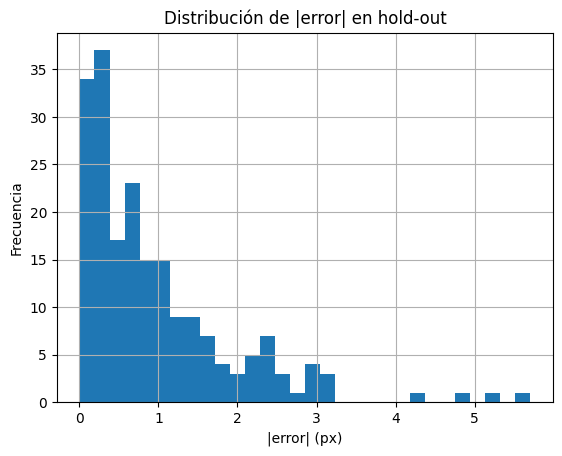

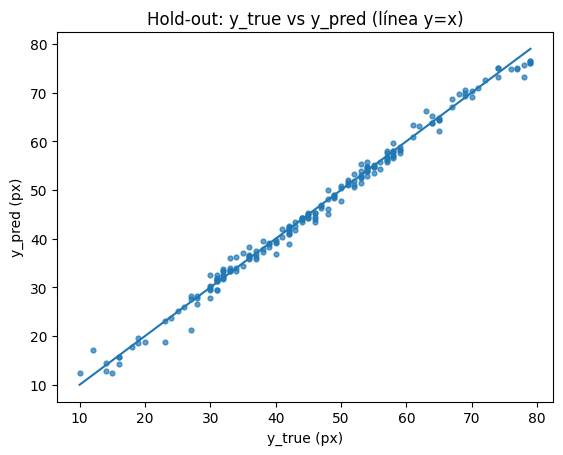

In [ ]:

# === 8) One‑Click Run ===
import os, glob, subprocess, sys
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 1) TRAIN (force to ensure run; guards still log/hash data)
print("▶️  Entrenando con guardas (force) ...")
ret = subprocess.run([sys.executable, "main.py", "--train", "--force"], check=False)
print("Código de retorno entrenamiento:", ret.returncode)

# 2) EVALUATE (alpha sweep)
print("\n▶️  Evaluación hold-out con α sweep ...")
from config import PATHS
from eval import evaluate_holdout

ck_full = sorted(Path(PATHS["ckpt_dir"]).glob("full_*.ckpt"))
ck_crop = next(iter(sorted(Path(PATHS["ckpt_dir"]).glob("crop_*.ckpt"))), None)
if not ck_full or ck_crop is None:
    raise SystemExit("No hay checkpoints. Revisa el paso de entrenamiento.")

candidates = (0.25, 0.5, 0.75)
results = []
for a in candidates:
    rep, y_true, y_pred = evaluate_holdout(ck_full, ck_crop, alpha=a)
    results.append((a, rep, y_true, y_pred))

best_alpha, best_rep, y_true, y_pred = min(results, key=lambda x: x[1]["MAE"])
print(f"\n✅ α óptimo = {best_alpha} (MAE = {best_rep['MAE']:.4f})")

# 3) EXPORT CSV (True vs Pred)
hold_df = pd.read_csv(PATHS["csv_hold"])
df = pd.DataFrame({
    "ID": hold_df["ID"].astype(int).values,
    "label": y_true,
    "pred":  y_pred
})
df["error"] = df["pred"] - df["label"]
df["abs_error"] = df["error"].abs()

reports_dir = Path(PATHS["csv_hold"]).parent.parent.parent / "reports"
reports_dir.mkdir(parents=True, exist_ok=True)
csv_out = reports_dir / "true_vs_pred_holdout.csv"
df.to_csv(csv_out, index=False)
print("📄 CSV guardado en:", csv_out)

# 4) CHARTS (matplotlib, 1 figura por gráfico, sin estilos ni colores definidos)
# 4A) Histograma de |error|
plt.figure()
df["abs_error"].hist(bins=30)
plt.title("Distribution |error| in hold-out")
plt.xlabel("|error| (px)")
plt.ylabel("Frecuency")
plt.show()

# 4B) Dispersión y_true vs y_pred
plt.figure()
plt.scatter(df["label"].values, df["pred"].values, s=12, alpha=0.7)
lims = [min(df["label"].min(), df["pred"].min()), max(df["label"].max(), df["pred"].max())]
plt.plot(lims, lims)
plt.title("Hold-out: y_true vs y_pred (línea y=x)")
plt.xlabel("y_true (px)")
plt.ylabel("y_pred (px)")
plt.show()
